In [1]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Render a textured mesh

This tutorial shows how to:
- load a mesh and textures from an `.obj` file. 
- set up a renderer 
- render the mesh 
- vary the rendering settings such as lighting and camera position
- use the batching features of the pytorch3d API to render the mesh from different viewpoints

## Import modules

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures

In [3]:
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader
)

# add path for demo utils
import sys
import os
sys.path.append(os.path.abspath(''))
from utils import image_grid

### Load a mesh and texture file

Load an `.obj` file and it's associated `.mtl` file and create a **Textures** and **Meshes** object. 

**Meshes** is a unique datastructure provided in PyTorch3d for working with batches of meshes of different sizes. 

**Textures** is an auxillary datastructure for storing texture information about meshes. 

**Meshes** has several class methods which are used throughout the rendering pipeline.

In [4]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
verts, faces, aux = load_obj(obj_filename)
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# Get textures from the outputs of the load_obj function
# the `aux` variable contains the texture maps and vertex uv coordinates. 
# Refer to the `obj_io.load_obj` function for full API reference. 
# Here we only have one texture map for the whole mesh. 
verts_uvs = aux.verts_uvs[None, ...].to(device)       # (N, V, 2)
faces_uvs = faces.textures_idx[None, ...].to(device)  # (N, F, 3)
tex_maps = aux.texture_images
texture_image = list(tex_maps.values())[0]
texture_image = texture_image[None, ...].to(device)   # (N, H, W, 3)

# Create a textures object
tex = Textures(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_image)

# Create a meshes object with textures
mesh = Meshes(verts=[verts], faces=[faces_idx], textures=tex)

/home/user/anaconda3/envs/pytorch3d/lib/python3.6/site-packages/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


#### Let's visualize the texture map

(-0.5, 1023.5, 1023.5, -0.5)

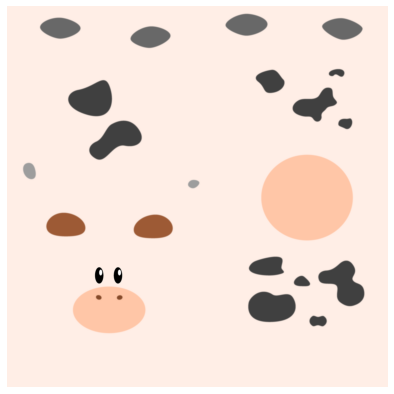

In [5]:
plt.figure(figsize=(7,7))
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.grid("off")
plt.axis('off')

## Create a renderer

A renderer in PyTorch3d is composed of a **rasterizer** and a **shader** which each have a number of subcomponents such as a **camera** (orthgraphic/perspective). Here we initialize some of these components and use default values for the rest.

In this example we will first create a **renderer** which uses a **perspective camera**, a **point light** and applies **phong shading**. Then we learn how to vary different components using the modular API.  

In [6]:
# Initialize an OpenGL perspective camera.
R, T = look_at_view_transform(2.7, 10, 20)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_meshes.py for explanations of these parameters. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size=0
)

# Place a point light in front of the object
lights = PointLights(device=device, location=[[1.0, 1.0, -2.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

## Render the mesh

The light is in front of the object so it is bright and the image has specular highlights.

(-0.5, 511.5, 511.5, -0.5)

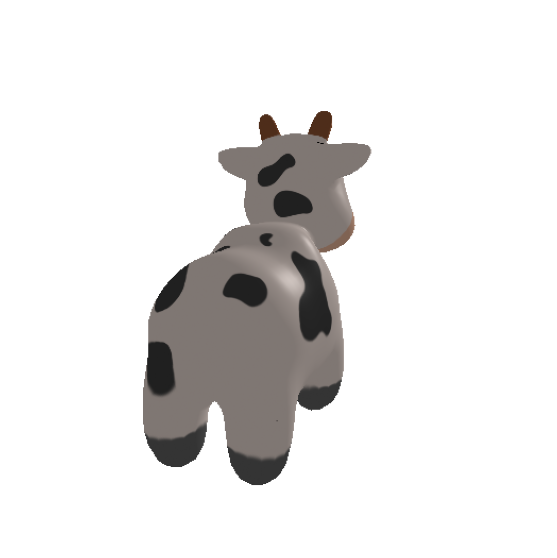

In [7]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")

## Move the light behind the object and re-render

We can pass arbirary keyword arguments to the `rasterizer`/`shader` via the call to the `renderer` so the renderer does not need to be reinitialized if any of the settings change/

In this case, we can simply update the location of the lights and pass them into the call to the renderer. 

The image is now dark as there is only ambient lighting, and there are no specular highlights.

In [8]:
lights.location = torch.tensor([0.0, 0.0, +1.0], device=device)[None]
images = renderer(mesh, lights=lights)

(-0.5, 511.5, 511.5, -0.5)

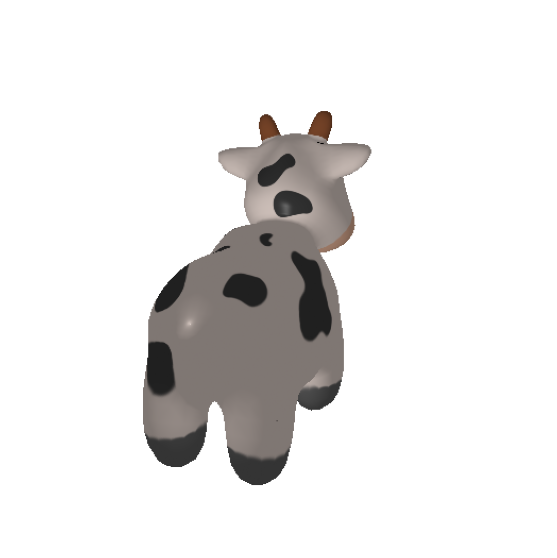

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")

## Rotate the object, modify the material properties or light properties

We can also change many other settings in the rendering pipeline. Here we:

- change the **viewing angle** of the camera
- change the **position** of the point light
- change the **material reflectance** properties of the mesh

In [10]:
# Rotate the object by increasing the azimuth angle
R, T = look_at_view_transform(dist=2.7, elev=0, azim=45,degrees=True)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Move the light location to be in front of the object again
lights.location = torch.tensor([[5.0, 5.0, -2.0]], device=device)

# Change specular color to green and change material shininess 
materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0]],
    shininess=10.0
)

# Re render the mesh, passing in keyword arguments for the modified components.
images = renderer(mesh, lights=lights, materials=materials, cameras=cameras)

(-0.5, 511.5, 511.5, -0.5)

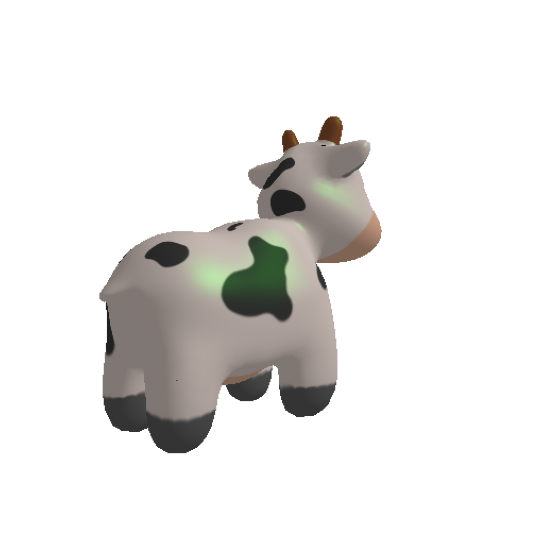

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")

## Batched Rendering

One of the core design choices of the PyTorch3d API is to suport **batched inputs for all components**. 
The renderer and associated components can take batched inputs and **render a batch of output images in one forward pass**. We will now use this feature to render the mesh from many different viewpoints.


In [12]:
# Set batch size - this is the number of different viewpoints from which we want to render the mesh.
batch_size = 20

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, batch_size)
azim = torch.linspace(0, 360, batch_size)

In [13]:
# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and specify dist=2.7 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Move the light back in front of the object
lights.location = torch.tensor([[1.0, 1.0, -5.0]], device=device)

In [14]:
# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras, lights=lights)

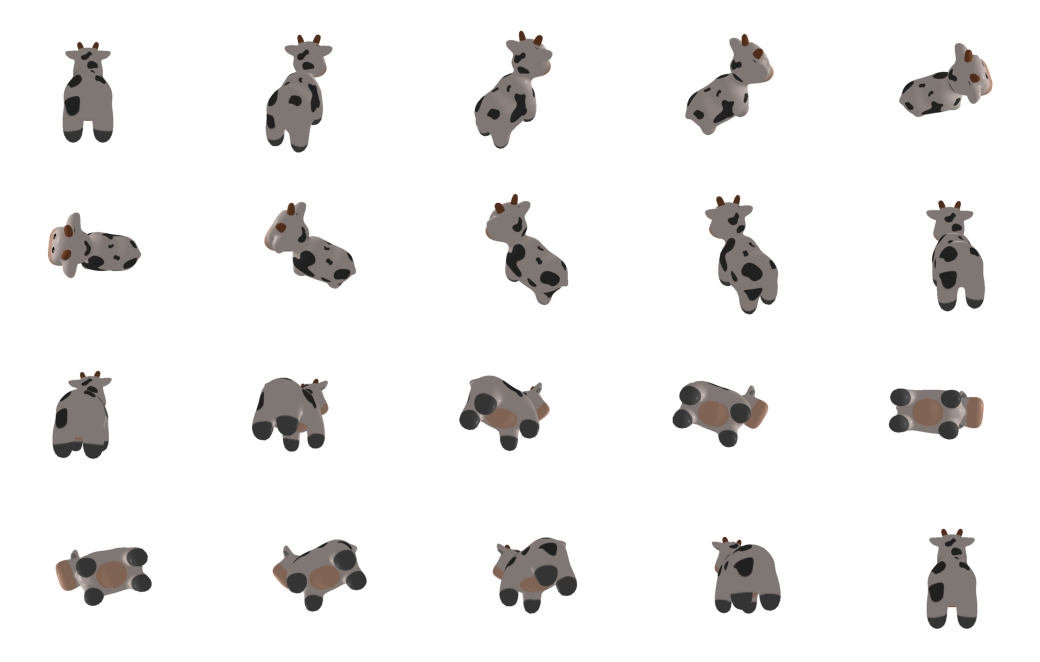

In [15]:
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)